In [1]:
# Some basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import warnings
import ast
import re
import statsmodels.api as sm


In [2]:
# Load the general data:
success_movies_path = 'data/processed_data/success_movies.csv'

success_movies_all = pd.read_csv(success_movies_path, sep=',')
success_movies_df =success_movies_all.dropna(subset=['diversity'])

success_movies_df= success_movies_df[success_movies_df["actor_number"] != 1]
success_movies_df.count()



Unnamed: 0                  13837
Movie_name                  13837
Movie_release_date          13837
Ratings                     13837
Wikipedia_movie_ID          13837
Actor_ethnicity             13837
Movie_countries             13837
Movie_box_office_revenue     1370
Nomination                  13837
Success                     13837
diversity                   13837
actor_number                13837
dtype: int64

## Regression


In [3]:
from sklearn.model_selection import train_test_split
# split the data into train and test sets using a 80-20 split
train, test = train_test_split(success_movies_df, test_size=0.2, random_state=42)

# print number of samples in the training and test sets
print(f"The number of samples in the training set is: {train.shape[0]}")
print(f"The number of samples in the test set is: {test.shape[0]}")

The number of samples in the training set is: 11069
The number of samples in the test set is: 2768


In [4]:
# split the data into features and target for the train and test datasets. 
# features contains all the columns minus the column price and label contains only the column price. 
# We will use this to train our model and then test it on the test set.
# Training features and target
features = ['Ratings', 'Nomination'] # 'Movie_box_office_revenue',
X_train = train[features]
y_train = train['diversity']

# testing features and target
X_test = test[features]
y_test = test['diversity']

# describe the training target variable
X_test.head()




,Ratings,Nomination
17743,8.0,False
15963,6.9,False
10800,3.6,False
7250,6.6,False
2331,7.8,True


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# we add constant column
X_train_scaled = sm.add_constant(X_train_scaled)

# we print the mean and standard deviation of the training set after standardization
print(f"The mean of the training set after standardization is:\n{X_train_scaled.mean()}")
print(f"The standard deviation of the training set after standardization:\n{X_train_scaled.std()}")

The mean of the training set after standardization is:
const         1.000000e+00
Ratings       7.073973e-16
Nomination   -2.599781e-17
dtype: float64
The standard deviation of the training set after standardization:
const         0.000000
Ratings       1.000045
Nomination    1.000045
dtype: float64


In [6]:
# print(X_train_scaled.isnull().sum())
print(X_train.isnull().sum())

Ratings       0
Nomination    0
dtype: int64


In [7]:
# train a linear regression model on the training dataset
model = sm.OLS(y_train, X_train_scaled).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              diversity   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     23.35
Date:                Thu, 12 Dec 2024   Prob (F-statistic):           7.62e-11
Time:                        17:48:39   Log-Likelihood:                -7653.7
No. Observations:               11069   AIC:                         1.531e+04
Df Residuals:                   11066   BIC:                         1.534e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5759      0.005    125.398      0.0

RMSE values for different regression models are as follows:

In [8]:
from sklearn.metrics import mean_squared_error

# standardize the test features 
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test, columns=X_test.columns, index=X_test.index)
X_test_scaled = sm.add_constant(X_test_scaled)

# make predictions on the test dataset
y_pred = model.predict(X_test_scaled)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f} ")

RMSE: 0.50 


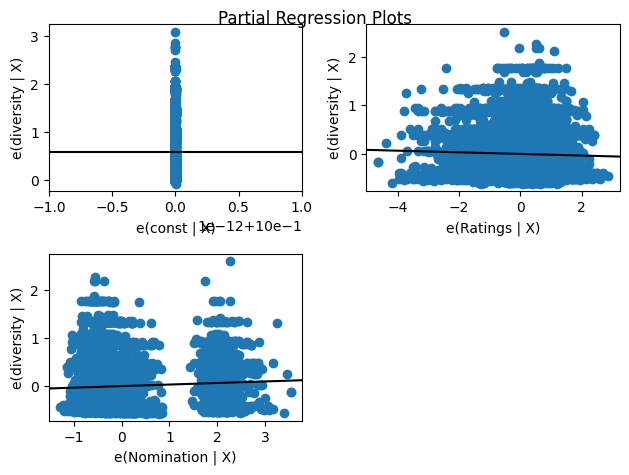

In [9]:
from statsmodels.graphics.regressionplots import plot_partregress_grid

fig = plot_partregress_grid(model)
fig.suptitle("Partial Regression Plots")
plt.show()

In [10]:
# Get the p-values from the model summary
p_values = model.pvalues
display(p_values)
# Display features with p-values < 0.05
significant_features = p_values[p_values < 0.05]
print("Statistically significant features (p-value < 0.05):")
print(significant_features)

const         0.000000e+00
Ratings       5.147793e-04
Nomination    2.624945e-11
dtype: float64

Statistically significant features (p-value < 0.05):
const         0.000000e+00
Ratings       5.147793e-04
Nomination    2.624945e-11
dtype: float64


In [11]:
# get the models coefficients
coefficients = model.params

# we sort these coefficients 
sorted_coefficients = coefficients.abs().sort_values(ascending=False)

# we keep the two features with the highest coef
top_2_features = sorted_coefficients.head(3)
print(top_2_features)

const         0.575906
Nomination    0.032247
Ratings       0.016788
dtype: float64


DOES DIVERSITY CAN PREDICT SUCESS OF A MOVIE?

In [14]:
# display the subset of succes_movies_df without the Nan on the subset of 'Movie_box_office_revenue'
success_predict = success_movies_all.dropna(subset=['Movie_box_office_revenue'])
success_predict = success_predict[success_predict["actor_number"] != 1]

success_predict.count()

Unnamed: 0                  1370
Movie_name                  1370
Movie_release_date          1370
Ratings                     1370
Wikipedia_movie_ID          1370
Actor_ethnicity             1370
Movie_countries             1370
Movie_box_office_revenue    1370
Nomination                  1370
Success                     1370
diversity                   1370
actor_number                1370
dtype: int64

In [15]:
# split the data into train and test sets using a 80-20 split
train, test = train_test_split(success_predict, test_size=0.2, random_state=42)

# regression as 'Movie_box_office_revenue' in the feature
features = ['Ratings', 'Nomination', 'Movie_box_office_revenue']	
X_train = train[features]
y_train = train['diversity']

# testing features and target
X_test = test[features]
y_test = test['diversity']

# standardize the training features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_train_scaled = sm.add_constant(X_train_scaled)

# train a linear regression model on the training dataset
model = sm.OLS(y_train, X_train_scaled).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              diversity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.03146
Date:                Thu, 12 Dec 2024   Prob (F-statistic):              0.992
Time:                        17:49:48   Log-Likelihood:                -798.47
No. Observations:                1096   AIC:                             1605.
Df Residuals:                    1092   BIC:                             1625.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

<Axes: xlabel='Nomination', ylabel='diversity'>

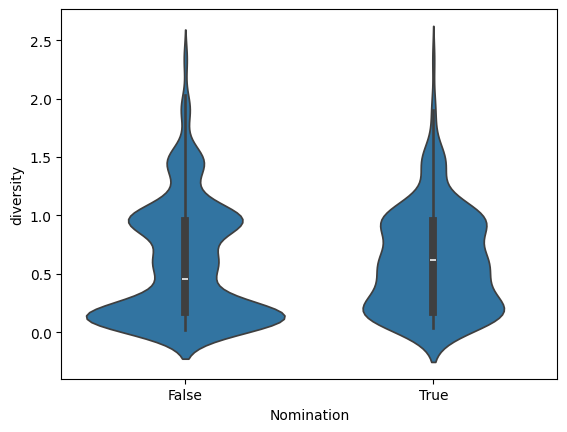

In [20]:
sns.violinplot(data=success_movies_df, x="Nomination", y="diversity") #, hue="diversity")

<Axes: xlabel='diversity', ylabel='Ratings'>

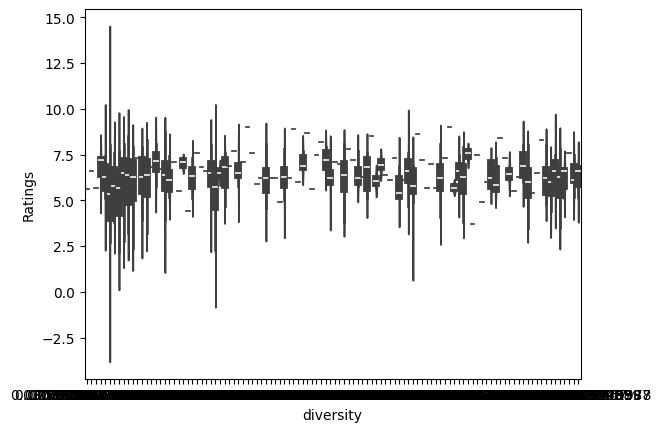

In [26]:
sns.violinplot(data=success_movies_df, x="diversity", y="Ratings") #, hue="diversity")